Tuesday, May 30, 2023

My walkthrough and playground for the [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

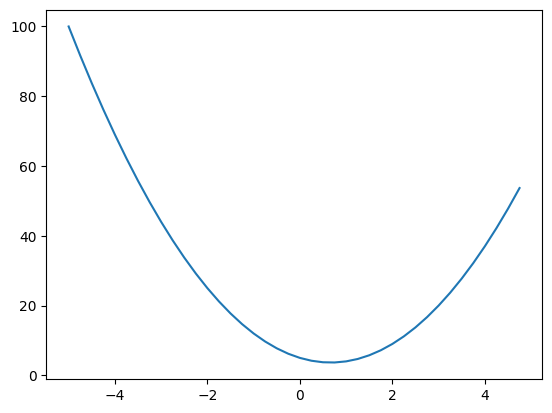

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.00001
x = 5
(f(x+h) - f(x))/h

26.000030000261628

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0

In [109]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
    
        return  out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        

In [26]:
a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a*b ; e.label='e'
d = e + c ; d.label='d'
f = Value(-2.0, label='f')
L = d * f ; L.label = 'L'

In [27]:
from graphviz import Digraph

In [28]:
# import graphviz  # doctest: +NO_EXE
# dot = graphviz.Digraph(comment='The Round Table')
# dot  #doctest: +ELLIPSIS


In [29]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
       # dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

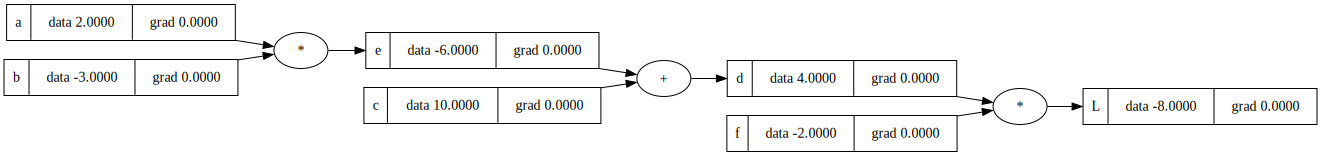

In [30]:
draw_dot(L)

In [31]:
L.grad = 1.0

f.grad = 4.0
d.grad = -2.0

c.grad = -2.0
e.grad = -2.0

a.grad = e.grad * b.data
b.grad = e.grad * a.data



In [32]:
def lol():
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b ; e.label='e'
    d = e + c ; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f ; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0 , label='a')
    b = Value(-3, label='b')
    b.data += h
    c = Value(10, label='c')
    e = a*b ; e.label='e'
    d = e + c ; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f ; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()

-3.9999999999995595


In [33]:
lr = 0.01
a.data += lr * a.grad
b.data += lr * b.grad
c.data += lr * c.grad
f.data += lr * f.grad


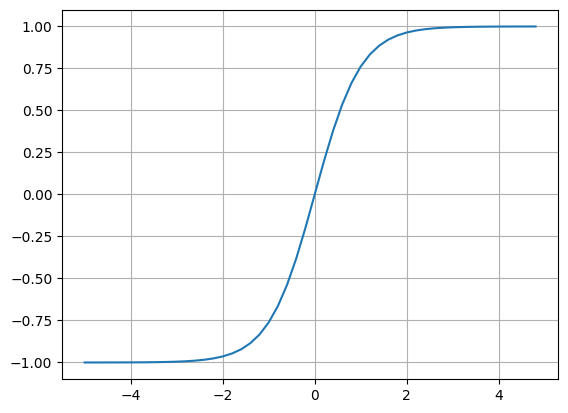

In [34]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [35]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

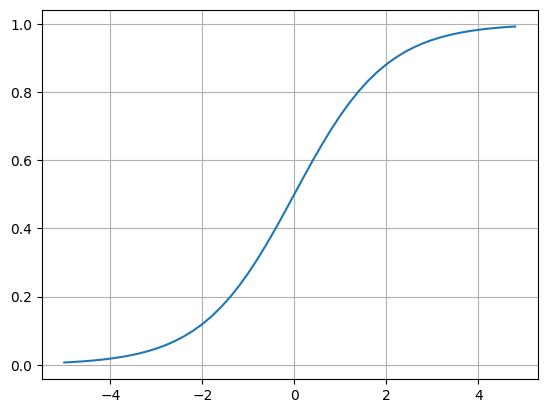

In [36]:
plt.plot(np.arange(-5,5,0.2), sigmoid(np.arange(-5,5,0.2)))
plt.grid()

In [110]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = '0'

In [47]:
o.grad = 1.0

In [ ]:
n.grad = 0.5

In [51]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [53]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [55]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [56]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

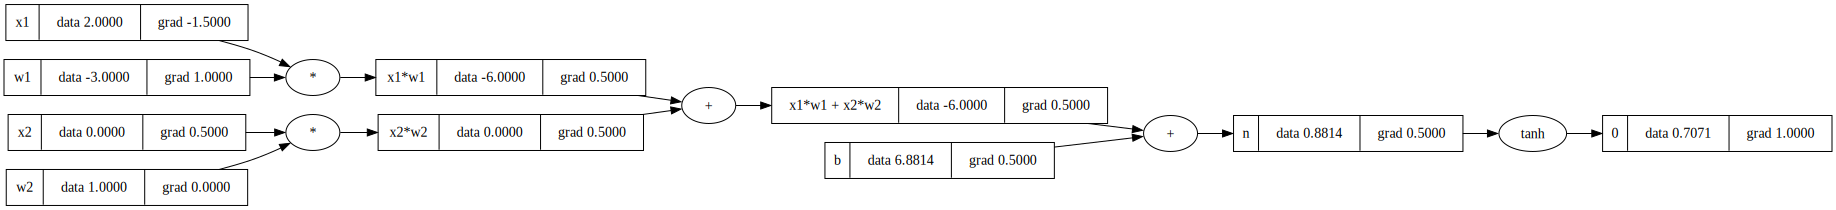

In [57]:
draw_dot(o)

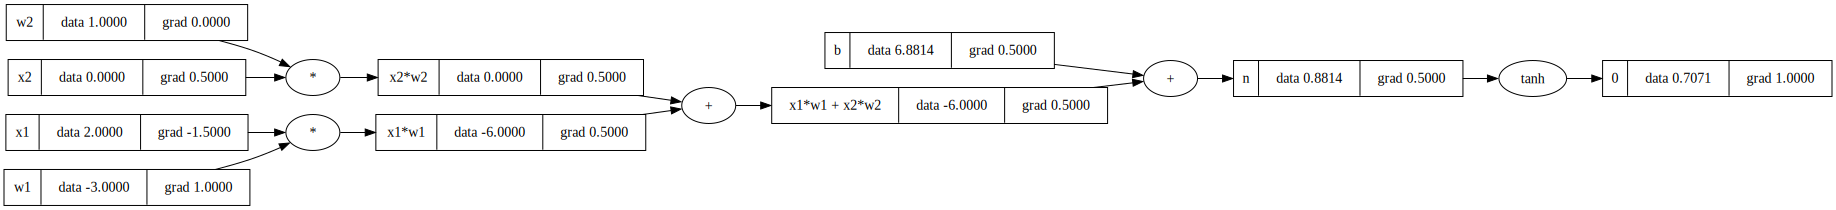

In [112]:
draw_dot(o)

In [102]:
o.grad = 1.0

In [103]:
o._backward()

In [104]:
n._backward()

In [105]:
x1w1x2w2._backward()

In [106]:
x1w1._backward()

In [107]:
x2w2._backward()

In [111]:
o.backward()